In [662]:
# Importing libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from unidecode import unidecode

In [41]:
# Loading the data from CSV file
data_raw = pd.read_csv('customer_vendas.csv',sep=';')

In [42]:
# Previewing the first 10 rows of the dataset
data_raw.head(10)

,Número de registros,Age,City,Customer Id,Date,Id (Operations),Id,Scholarship,Sex,Value
0,1,25,São Paulo,18,09/05/2018,1,18,Ensino Superior,F,"798,76"
1,1,28,Mato Grosso,4,12/04/2018,2,4,Ensino Superior,M,"383,87"
2,1,37,Rio de Janeiro,39,02/05/2018,3,39,Ensino Médio,M,"595,83"
3,1,43,São Paulo,14,07/07/2018,4,14,Ensino Médio,F,"954,76"
4,1,30,Rio de Janeiro,2,16/04/2018,5,2,Ensino Superior,M,"267,24"
5,1,36,Pará,48,28/05/2018,6,48,Ensino Superior,F,815
6,1,28,São Paulo,11,26/06/2018,7,11,Ensino Médio,F,"483,86"
7,1,40,Rio Grande do Sul,3,12/04/2018,8,3,Ensino Superior,M,"139,76"
8,1,34,São Paulo,25,02/04/2018,9,25,Ensino Superior,F,"286,15"
9,1,25,São Paulo,18,23/05/2018,10,18,Ensino Superior,F,"421,73"


In [121]:
# Getting some metadata info about the dataset
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Número de registros  497 non-null    int64 
 1   Age                  497 non-null    int64 
 2   City                 497 non-null    object
 3   Customer Id          497 non-null    int64 
 4   Date                 497 non-null    object
 5   Id (Operations)      497 non-null    int64 
 6   Id                   497 non-null    int64 
 7   Scholarship          497 non-null    object
 8   Sex                  497 non-null    object
 9   Value                497 non-null    object
dtypes: int64(5), object(5)
memory usage: 39.0+ KB


## Data Wrangling

### Casting

In [124]:
# Copying the 'data_raw' dataset to a new one whose columns are going to be type-casted
data_casted = data_raw.copy()

In [125]:
# Type-casting the appropriate columns
data_casted['Date'] = pd.to_datetime(data_raw['Date'])
data_casted['Value'] = data_casted['Value'].apply(lambda str_value: str_value.replace(',','.')).astype(float)

# Featuring the columns' new data types
data_casted.info(memory_usage=False,show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 10 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Número de registros  int64         
 1   Age                  int64         
 2   City                 object        
 3   Customer Id          int64         
 4   Date                 datetime64[ns]
 5   Id (Operations)      int64         
 6   Id                   int64         
 7   Scholarship          object        
 8   Sex                  object        
 9   Value                float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)

### Normalizing columns

In [138]:
# Creating function 'column_names_normalizer' to normalize the dataset columns' names
def column_names_normalizer(columns):
    normalized_cols = {}
    
    for col_name in columns:
        normalized_cols[col_name] = re.sub(
            # 3rd transform: this regex substitution removes all special characters (except blank spaces because it's gonna be replaced)
            '[^A-Za-z0-9 ]+',
            '',
            # 1st transform: the 'unidecode' function replaces accent letters for its non-accented version
            # 2nd transform: the 'lower' function transforms all uppercase letters in lowercase
            unidecode(col_name).lower()) \
        .replace(' ','_') # 4th transform: replace blank spaces by underscores \
    
    return normalized_cols

In [140]:
# Normalizing column names and saving it into the 'data_transformed' dataframe
data_transformed = data_casted.rename(columns = column_names_normalizer(data_casted.columns))

# Featuring the renamed columns
list(data_transformed.columns)

['numero_de_registros',
 'age',
 'city',
 'customer_id',
 'date',
 'id_operations',
 'id',
 'scholarship',
 'sex',
 'value']

### Cleansing

In [179]:
# Initializing the list of columns to be excluded
columns_to_remove = []

In [180]:
# Getting the count of distinct values for all the dataset's columns
data_transformed.nunique()

numero_de_registros      1
age                     27
city                    12
customer_id             50
date                   100
id_operations          497
id                      50
scholarship              2
sex                      2
value                  495
dtype: int64

In [181]:
# The 'numero_de_registros' column has a single value, which we know it's "1"
# due the data previewing we've made previously, thus we are going to add it to the list of columns to remove
columns_to_remove.append('numero_de_registros')

In [182]:
# Previewing the data I could observe that columns 'cutomer_id' and 'id' APPARENTLY have ALWAYS the same value.
# On the counting of distinct values for each column, the fact that both have the same number of distinct values (50)
# corroborates with this theory. In order to confirm this suspicion, lets compare their values in all rows.
# The comparison generates a series with the differences. If the series is empty it means that both have the same values
data_transformed['customer_id'].compare(data_transformed['id']).empty

True

In [183]:
# As our suspicion was confirmed, we must get rid of one of the columns. I'm going to choose 'id' to remove and
# keep 'customer_id' column, assuming it represents indeed a customer's unique identification.
columns_to_remove.append('id')

In [464]:
# Removing the appropriate columns
data_reduced = data_transformed.drop(columns = columns_to_remove)

In [465]:
# Verifying whether there is any duplicated rows on the dataset (there is not)
any(data_reduced.duplicated())

False

### Enrichment

In [606]:
# Making a copy from 'data_reduced'
data_enriched = data_reduced.copy()
# Initializing new columns
macro_region = []
age_group = []

In [607]:
# Categorizing the cities by macro-region
for city in data_reduced['city']:
    if city in ['São Paulo','Rio de Janeiro','Minas Gerais']:
        macro_region.append('Southeast')
    elif city in ['Mato Grosso','Goiás']:
        macro_region.append('West-central')
    elif city in ['Pará','Acre']:
        macro_region.append('North')
    elif city in ['Rio Grande do Sul','Paraná','Santa Catarina']:
        macro_region.append('South')
    elif city in ['Bahia','Pernambuco']:
        macro_region.append('Northeast')
    else:
        macro_region.append(None)

In [608]:
# Inserting new column 'macro_region'
data_enriched.insert(2,'macro_region', macro_region)

In [609]:
# Creating the age groups
for age in data_reduced['age']:
    if 16 <= age <= 20:
        age_group.append('16-20')
    elif 21 <= age <= 25:
        age_group.append('21-25')
    elif 26 <= age <= 30:
        age_group.append('26-30')
    elif 31 <= age <= 35:
        age_group.append('31-35')
    elif 36 <= age <= 40:
        age_group.append('36-40')
    elif 41 <= age <= 45:
        age_group.append('41-45')
    elif 46 <= age <= 50:
        age_group.append('46-50')
    elif 51 <= age <= 56:
        age_group.append('51-56')
    else:
        age_group.append(None)

In [611]:
# Inserting new column 'macro_region'
data_enriched.insert(8,'age_group', age_group)

## Exploratory Data Analysis 

### Geographic analysis

In [334]:
# Checking the 'city' column's values distribution (quantity of sales by city) and sorting list descending by quantity
city_distribution = data_enriched.groupby('city').size().sort_values(ascending=False)

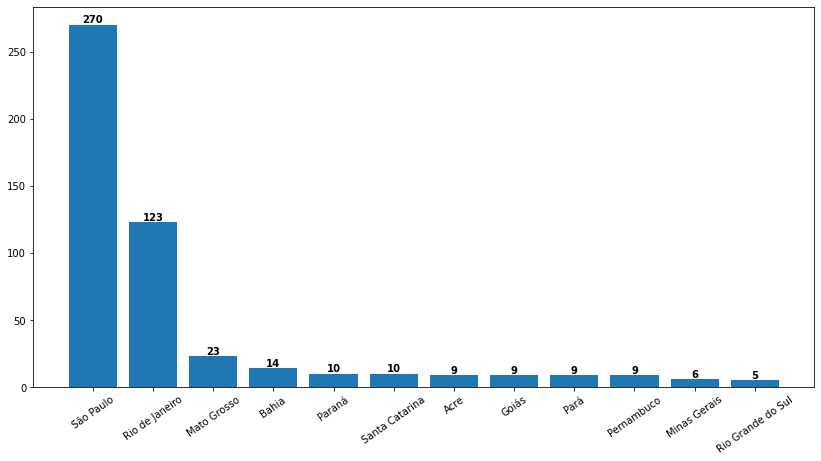

In [331]:
# Showing the quantity of sales by city
plt.figure(figsize=(14,7))
plt.bar(city_distribution.index, city_distribution.values)
plt.xticks(rotation=35)

for i in range(len(city_distribution.values)):
    plt.annotate(
        city_distribution[i],
        xy=(city_distribution.index[i], city_distribution.values[i]),
        va='bottom',
        ha='center',
        size='medium',
        weight='bold')
    
plt.show()

In [419]:
# Calculating the cities' average ticket
data_enriched.groupby('city')['value'].mean().sort_values(ascending=False)

city
Acre                 843.942222
Goiás                799.842222
Pará                 759.574444
São Paulo            610.321481
Minas Gerais         597.465000
Rio de Janeiro       560.714553
Pernambuco           559.293333
Paraná               538.489000
Santa Catarina       485.352000
Mato Grosso          463.256087
Rio Grande do Sul    433.070000
Bahia                371.203571
Name: value, dtype: float64

In [471]:
# Counting the number of sales by macro region
macro_region_count = data_enriched.groupby('macro_region').size()

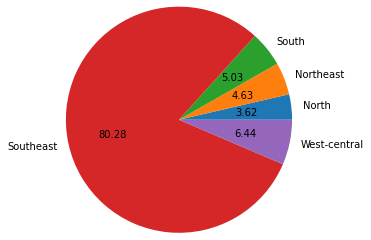

In [491]:
# Featuring the distribution of sales between all the macro regions
plt.pie(macro_region_count.values, labels=macro_region_count.index, radius=1.3, autopct='%.2f')
plt.show()

### Seasonality analysis

In [420]:
# Aggregating the number of sales by month
monthly_sales = data_enriched \
    .groupby(data_transformed['date'].dt.strftime('%Y-%m')) \
    .size() \
    .sort_index()

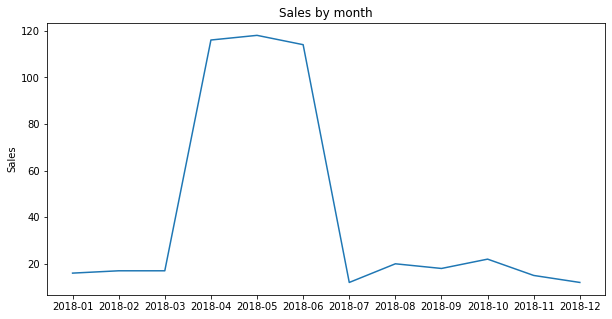

In [772]:
# Featuring the monthly sales
fig, ax = plt.subplots()
# plt.figure(figsize=(10,5))
ax.plot(monthly_sales.index, monthly_sales.values)
ax.set_title('Sales by month')
ax.set_ylabel('Sales')

fig.set_size_inches(10,5)
plt.show()

In [502]:
# Due the analysis of sales distribution between the cities and macro regions, we know that 80% of the sales
# took place in Southeast, specially São Paulo and Rio de Janeiro. Therefore, may be appropriated do a
# seasonality analysis by macro region and compare their results afterwards.

# Creating lists for each macro region, containing the number of sales by month

# SOUTHEAST list
southeast_monthly_sales = data_enriched \
    .query("macro_region == 'Southeast'") \
    .groupby(data_transformed['date'].dt.strftime('%Y-%m')) \
    .size() \
    .sort_index()

# SOUTH list
south_monthly_sales = data_enriched \
    .query("macro_region == 'South'") \
    .groupby(data_transformed['date'].dt.strftime('%Y-%m')) \
    .size() \
    .sort_index()

# NORTHEAST list
northeast_monthly_sales = data_enriched \
    .query("macro_region == 'Northeast'") \
    .groupby(data_transformed['date'].dt.strftime('%Y-%m')) \
    .size() \
    .sort_index()

# NORTH list
north_monthly_sales = data_enriched \
    .query("macro_region == 'North'") \
    .groupby(data_transformed['date'].dt.strftime('%Y-%m')) \
    .size() \
    .sort_index()

# WEST-CENTRAL list
west_central_monthly_sales = data_enriched \
    .query("macro_region == 'West-central'") \
    .groupby(data_transformed['date'].dt.strftime('%Y-%m')) \
    .size() \
    .sort_index()

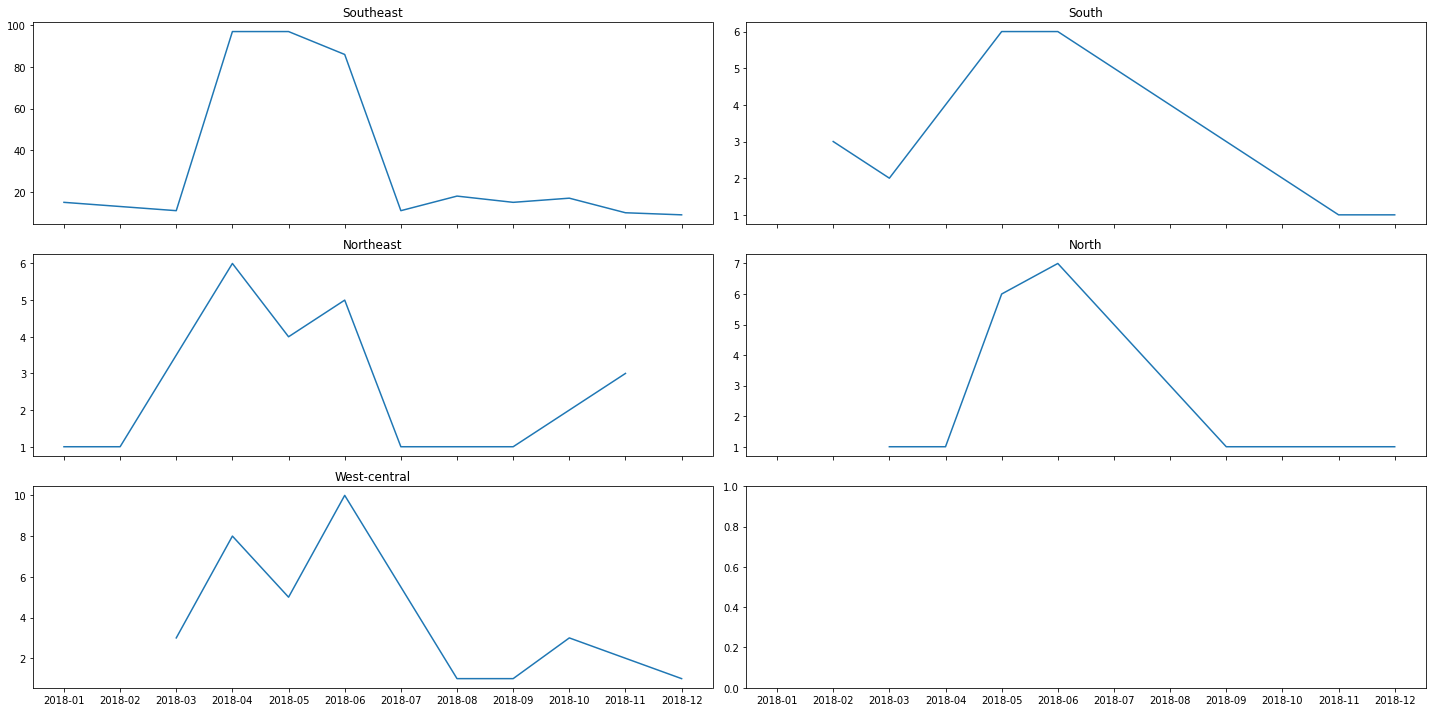

In [766]:
# Featuring the monthly sales for each macro region to allow the comparison
fig, axes = plt.subplots(nrows=3,ncols=2,sharex=True)
se, s, ne, n, wc, _ = axes.flatten()

se.plot(southeast_monthly_sales.index, southeast_monthly_sales.values)
se.set_title('Southeast')

s.plot(south_monthly_sales.index, south_monthly_sales.values)
s.set_title('South')

ne.plot(northeast_monthly_sales.index, northeast_monthly_sales.values)
ne.set_title('Northeast')

n.plot(north_monthly_sales.index, north_monthly_sales.values)
n.set_title('North')

wc.plot(west_central_monthly_sales.index, west_central_monthly_sales.values)
wc.set_title('West-central')

fig.set_size_inches(20,10)
fig.tight_layout()
plt.show()

### Customer profile analysis

<AxesSubplot:title={'center':'age'}, xlabel='macro_region'>

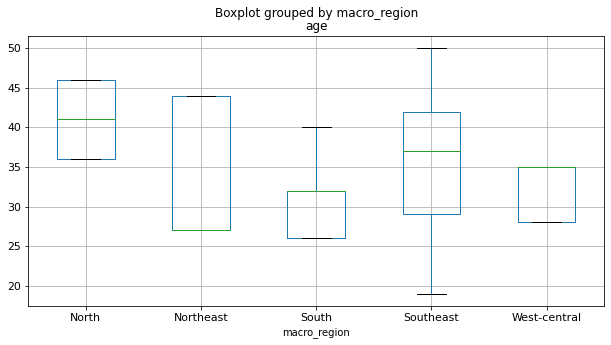

In [529]:
# Showing the boxplots of customers' ages grouped by macro regions 
data_enriched.boxplot(column='age',by='macro_region',fontsize=11,figsize=(10,5))

In [517]:
# Some macro regions has a strange bloxplot due its poor representiveness, as shown below. In fact, 80% of customers
# are from southeast region
data_enriched.groupby('macro_region')['customer_id'].nunique()

macro_region
North            2
Northeast        2
South            3
Southeast       40
West-central     3
Name: customer_id, dtype: int64

In [777]:
# Creating important aggregations regarding age groups to present graphically right after

# Distribution of customers
customers_age_group = data_enriched.groupby('age_group')['customer_id'].nunique()

# Volume of sales
sales_age_group = data_enriched.groupby('age_group').size()

# Average ticket
avg_ticket_age_group = data_enriched.groupby('age_group')['value'].mean().round()

# Distribution of customers by gender
male_customers = data_enriched.query("sex == 'M'").groupby('age_group')['customer_id'].nunique()
female_customers = data_enriched.query("sex == 'F'").groupby('age_group')['customer_id'].nunique()

# Volume of sales by gender
male_sales = data_enriched.query("sex == 'M'").groupby('age_group').size()
female_sales = data_enriched.query("sex == 'F'").groupby('age_group').size()

# Average ticket by gender
avg_ticket_male = data_enriched.query("sex == 'M'").groupby('age_group')['value'].mean().round()
avg_ticket_female = data_enriched.query("sex == 'F'").groupby('age_group')['value'].mean().round()

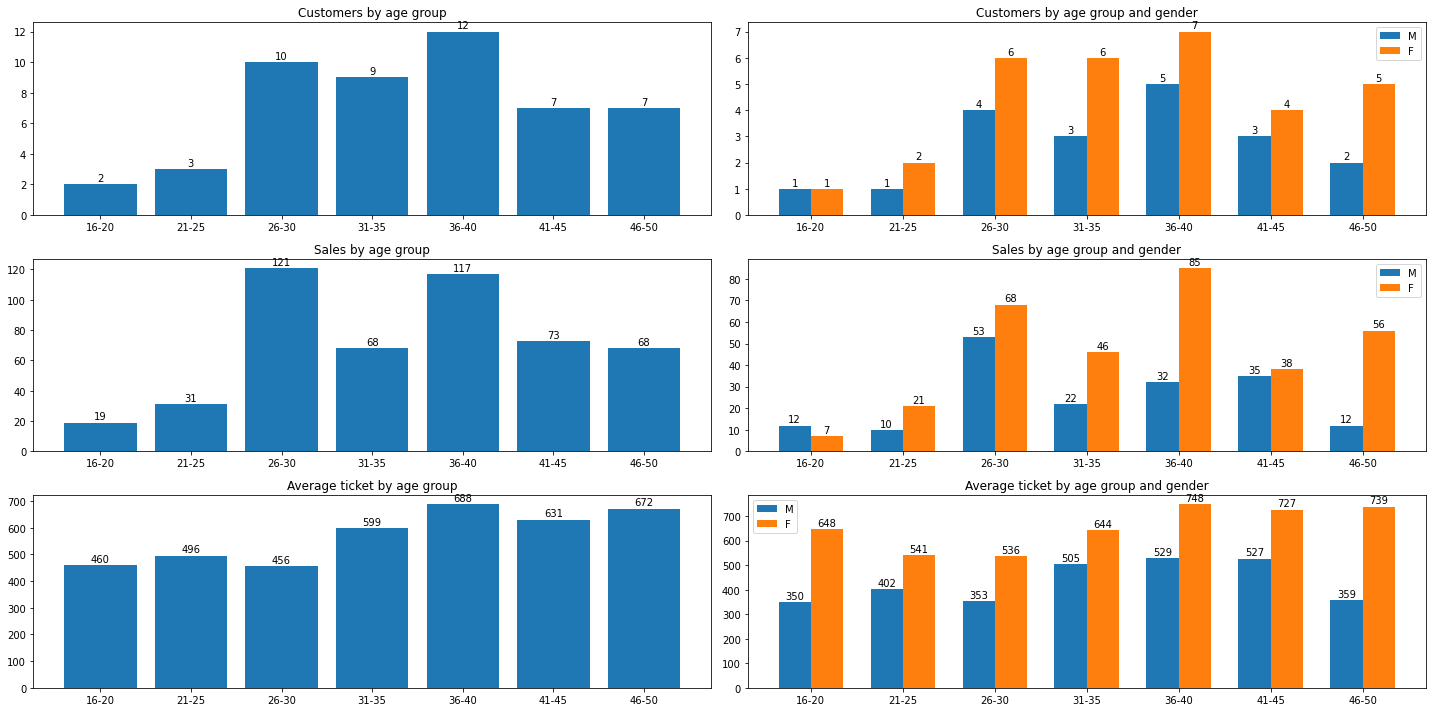

In [779]:
# Showing all the aggregations grouped by age group

age_groups = avg_ticket_female.index
fig, axes = plt.subplots(nrows=3,ncols=2)
x = np.arange(len(age_groups))
width = 0.35

g1, g2, g3, g4, g5, g6 = axes.flatten()

# Distribution of customers by age group
bar1 = g1.bar(customers_age_group.index, customers_age_group.values)
g1.bar_label(bar1, padding=1)
g1.set_title('Customers by age group')

# Customers distribution by age group and gender
bar1 = g2.bar(x - width/2, male_customers.values, width, label='M')
bar2 = g2.bar(x + width/2, female_customers.values, width, label='F')

g2.set_title('Customers by age group and gender')
g2.set_xticks(x)
g2.set_xticklabels(labels)
g2.legend()

g2.bar_label(bar1, padding=1)
g2.bar_label(bar2, padding=1)

# Distribution of sales by age group
bar1 = g3.bar(sales_age_group.index, sales_age_group.values)
g3.bar_label(bar1,padding=1)
g3.set_title('Sales by age group')

# Volume of sales by age group and gender
bar1 = g4.bar(x - width/2, male_sales.values, width, label='M')
bar2 = g4.bar(x + width/2, female_sales.values, width, label='F')

g4.set_title('Sales by age group and gender')
g4.set_xticks(x)
g4.set_xticklabels(labels)
g4.legend()

g4.bar_label(bar1, padding=1)
g4.bar_label(bar2, padding=1)

# Average ticket by age group
bar1 = g5.bar(avg_ticket_age_group.index, avg_ticket_age_group.values)
g5.bar_label(bar1,padding=1)
g5.set_title('Average ticket by age group')

# Average ticket by age group and gender
bar1 = g6.bar(x - width/2, avg_ticket_male.values, width, label='M')
bar2 = g6.bar(x + width/2, avg_ticket_female.values, width, label='F')

g6.set_title('Average ticket by age group and gender')
g6.set_xticks(x)
g6.set_xticklabels(labels)
g6.legend()

g6.bar_label(bar1, padding=1)
g6.bar_label(bar2, padding=1)


fig.set_size_inches(20,10)
fig.tight_layout()
plt.show()

In [780]:
# Preparing data to compare sales by customers with different scholarship 
x_sup = data_enriched.query("scholarship == 'Ensino Superior'")['value']
y_sup = data_enriched.query("scholarship == 'Ensino Superior'")['age_group'].sort_values()

x_med = data_enriched.query("scholarship == 'Ensino Médio'")['value']
y_med = data_enriched.query("scholarship == 'Ensino Médio'")['age_group'].sort_values()

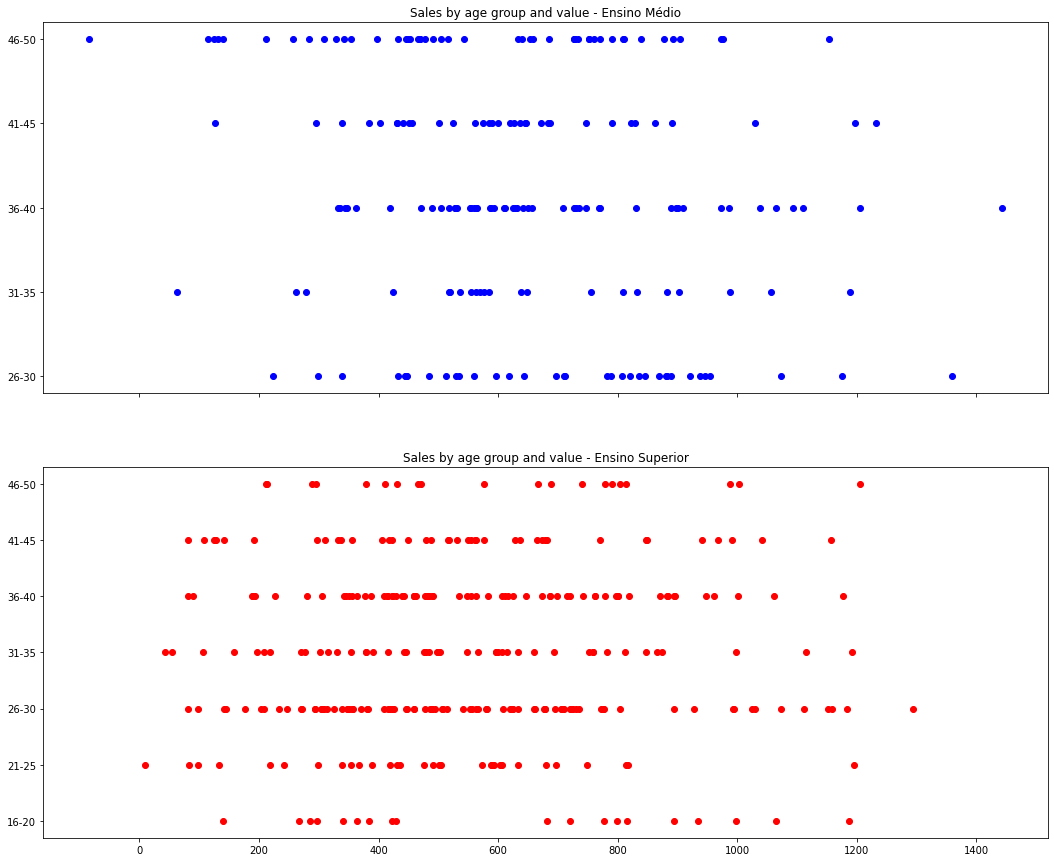

In [783]:
# Featuring scatter graph of sales by age group and value

fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True)
g1, g2 = ax.flatten()

g1.scatter(x_med, y_med, c='blue')
g1.set_title('Sales by age group and value - Ensino Médio')

g2.scatter(x_sup, y_sup, c='red')
g2.set_title('Sales by age group and value - Ensino Superior')

fig.set_size_inches(18,15)
plt.show()

In [764]:
# Average ticket by scholarship
data_enriched.query("sex == 'M'").groupby('scholarship')['value'].mean().round(2)

scholarship
Ensino Médio       522.56
Ensino Superior    409.60
Name: value, dtype: float64